----

# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización: Importar librerías

Antes de comenzar, se cargan las librerías pandas, numpy, scipy y matplotlib

In [45]:
import pandas as pd
import numpy as np 
from scipy import stats as st
from matplotlib import pyplot as plt

## Cargar los datos: lectura de los archivos csv

Los datos provienen de distintos dataframes que se cargan a continuación.

In [46]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Preparación de los datos

A continuación se revisará cada dataframe inicial, haciendo correcciones de estos si se considera necesario como parte del preprocesamiento de datos. Para realizar esto, se usará el método info.() junto con la impresión de una muestra del dataframe. Ambos elementos qentregarán un buen resumen de cada dataframe.

## Planes

In [47]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [48]:
plans.head(10)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Esta tabla no tiene datos ausentes y  sirve como referencia para entender que es lo que incluye cada plan que ofrece Megaline: Surf y Ultimate.

## Usuarios

In [49]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [50]:
users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


Si bien se observan datos NaN para churn date, esta variable indica cuando los usuarios cancelan el servicio, y se mide como el día después de que una suscripción se cancela o expira. Que estos datos aparezcan como NaN solo quiere decir que la suscrición al servicio sigue activa, por lo que no es necesario rellenar dichos datos faltantes mediante algún cáculo matemático, pero si se cambiará el valor de NaN a "active customer", para indicar que el usuario es un cliente activo de Megaline.

### Corrección de datos

In [51]:
users['churn_date'] = users['churn_date'].fillna('active customer')
users.head(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,active customer
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,active customer
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,active customer
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,active customer
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,active customer


## Llamadas

In [52]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [53]:
calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


No se observan datos ausentes, pero si se podrían hacer ajustes a algunas variables. La columna call_date será convertida al formato Y-m-d, y a partir de ella se generará una nueva columna: month. Es útil tener una columna con la información desagregada del mes ya que la empresa Megaline realiza cobros mensuales a sus usuarios.
Por otra parte, Megaline indica que para llamadas, cada llamada individual se redondea, y que incluso si la llamada dura solo un segundo, esta se redondea a un minuto, por lo que los valores de la duración de la llamada pueden redondearse hacia arriba. 

### Corrección de datos

In [54]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')

### Enriquecimiento de datos

Se va a agregar el mes de cada llamada. Se considera que dicha variable puede ser de utilidad ya que las compañías de celular hacen cobros mensuales, por lo que es interesante tener esa información desagregada de la fecha en formato Y-m-d.

In [55]:
calls['month'] = calls['call_date'].dt.month

In [56]:
calls['duration'] = np.ceil(calls['duration']).astype(int)


Para visualizar los cambios, se imprime una muestra del dataframe "calls".

In [57]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


## Mensajes

In [58]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [59]:
messages.head(10)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


No hay datos ausentes. La información de message_date será convertida al formado datetime y se agregará la columna month.

### Corrección de datos

In [60]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')

### Enriquecimiento de datos

In [61]:
messages['month'] = messages['message_date'].dt.month

Para visualizar los cambios, se imprime una muestra del dataframe "messages".

In [62]:
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [63]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [64]:
internet.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


No se observan datos ausentes para internet. La variable session_date será convertida a su formato datetime. Nuevamente, se agregará la columna month al dataframe. Además, será útil crear una nueva columna que mida el volumen del tráfico web en gigabytes por mes en vez de megabytes. Para realizar esta operación se dividirá el valor en megabytes por 1024, ya que hay 1024 megabyteas en un gigabyte.

### Corrección de datos

In [87]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')

### Enriquecimiento de datos

In [88]:
internet['month'] = internet['session_date'].dt.month

In [183]:
internet_used = internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum').reset_index()
internet_used.columns = ['user_id','month','mb_used_monthly']


In [185]:
internet['gb_used_monthly']=np.ceil(internet_used['mb_used_monthly']/1024).astype(int)
internet

,id,user_id,session_date,mb_used,month,gb_used_monthly
0,1000_13,1000,2018-12-29,89.86,12,2.0
1,1000_204,1000,2018-12-31,0.00,12,7.0
2,1000_379,1000,2018-12-28,660.40,12,14.0
3,1000_413,1000,2018-12-26,270.99,12,22.0
4,1000_442,1000,2018-12-27,880.22,12,19.0
...,...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10,NaN
104821,1499_216,1499,2018-12-30,304.72,12,NaN
104822,1499_217,1499,2018-09-22,292.75,9,NaN
104823,1499_218,1499,2018-12-07,0.00,12,NaN


Para visualizar los cambios, se imprime una muestra del dataframe "internet".

In [186]:
internet.head()

,id,user_id,session_date,mb_used,month,gb_used_monthly
0,1000_13,1000,2018-12-29,89.86,12,2.0
1,1000_204,1000,2018-12-31,0.00,12,7.0
2,1000_379,1000,2018-12-28,660.40,12,14.0
3,1000_413,1000,2018-12-26,270.99,12,22.0
4,1000_442,1000,2018-12-27,880.22,12,19.0


## Estudio de las condiciones de cada plan

Se vuelven a presentar las condiciones de uso que tiene cada plan de Megaline.

In [187]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Datos por usuario


A continuación se describirá el comportamiento de cada usuario al momento de hacer uso de su plan de Megaline. En primer lugar, se muestra la cantidad de llamadas que cada usuario realizó cada mes.

In [188]:
calls_per_month = calls.pivot_table(index=['user_id','month'], values='id', aggfunc='count').reset_index()
calls_per_month.columns = ['user_id','month','calls_amount']
calls_per_month

,user_id,month,calls_amount
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


Luego se muestra cuántos minutos fueron usados por mes por cada usuario.

In [189]:
min_used = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc='sum').reset_index()
min_used.columns = ["user_id","month","min_amount"]
min_used

,user_id,month,min_amount
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2253,1498,12,339
2254,1499,9,346
2255,1499,10,385
2256,1499,11,308


En el ámbito de la mensajería, se calcula el número de mensajes enviados por cada usuario por mes.

In [190]:
messages_sent = messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count').reset_index()
messages_sent.columns = ['user_id','month','messages_amount']
messages_sent

,user_id,month,messages_amount
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


Finalmente, para evaluar el uso de datos móviles, se calcula en GB la cantidad de tráfico usado por cada usuario por cada mes.

Toda esta información anterior será puesta de manera conjunta en un dataframe que representa el consumo de cada usario en un mes determinado. Para realizar esto, se usará el método merge, usando como punto de unión el usuario y el mes. La unión será de tipo "outer" para conservar elementos de todos los dataframes previos relacionados a los datos por usuario.

In [191]:
combined_data = calls_per_month.merge(min_used, on=['user_id','month'], how='outer') \
                              .merge(messages_sent, on=['user_id','month'], how='outer') \
                              .merge(mobile_data, on=['user_id','month'], how='outer')
combined_data

,user_id,month,calls_amount,min_amount,messages_amount,gb_used_monthly
0,1000,12,16.0,124.0,11.0,64.0
1,1001,8,27.0,182.0,30.0,393.0
2,1001,9,49.0,315.0,44.0,1001.0
3,1001,10,65.0,393.0,53.0,881.0
4,1001,11,64.0,426.0,36.0,959.0
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,0.0
2289,1361,5,NaN,NaN,2.0,0.0
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,0.0


Al imprimir una muestra del dataframe conjunto, se observan muchos datos NaN, lo que se debe a que distintos usuarios hacen distintos usos de sus planes móviles. A continuación se añadirá el plan de Megaline que utiliza cada usuario.

In [192]:
plan_info = combined_data.merge(users[['user_id', 'plan']], on='user_id', how='left')
plan_info

,user_id,month,calls_amount,min_amount,messages_amount,gb_used_monthly,plan
0,1000,12,16.0,124.0,11.0,64.0,ultimate
1,1001,8,27.0,182.0,30.0,393.0,surf
2,1001,9,49.0,315.0,44.0,1001.0,surf
3,1001,10,65.0,393.0,53.0,881.0,surf
4,1001,11,64.0,426.0,36.0,959.0,surf
...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,0.0,surf
2289,1361,5,NaN,NaN,2.0,0.0,surf
2290,1482,10,NaN,NaN,2.0,NaN,ultimate
2291,1108,12,NaN,NaN,NaN,0.0,ultimate


Finalmente, se calculará cuántos ingresos genera cada usuario. Para esto, primero se añadirá información sobre el costo adicional que tiene cada servicio una vez que un usuario excede los límites de su plan.

In [193]:
user_info = plan_info.loc[:, ['user_id', 'month', 'plan']]
plans.rename(columns={'plan_name': 'plan'}, inplace=True)
user_info_bis = (user_info.merge(plans, on=['plan'], how='outer'))
user_info_bis

,user_id,month,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1006,11,ultimate,1000,30720,3000,70,7,0.01,0.01
2,1006,12,ultimate,1000,30720,3000,70,7,0.01,0.01
3,1008,10,ultimate,1000,30720,3000,70,7,0.01,0.01
4,1008,11,ultimate,1000,30720,3000,70,7,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...
2288,1194,12,surf,50,15360,500,20,10,0.03,0.03
2289,1349,10,surf,50,15360,500,20,10,0.03,0.03
2290,1349,11,surf,50,15360,500,20,10,0.03,0.03
2291,1349,12,surf,50,15360,500,20,10,0.03,0.03


A continuación, se unen dataframes que representa el consumo de cada usuario junto al costo adicional que representa él exceder los límites de su plan.

In [194]:
monthly_revenue_info = (calls_per_month
              .merge(messages_sent, on=['user_id','month'],how='outer')
              .merge(mobile_data, on=['user_id','month'], how='outer')
              .merge(min_used, on=['user_id','month'], how='outer')
              .merge(user_info_bis, on=['user_id', 'month'], how='outer')
             )
monthly_revenue_info

,user_id,month,calls_amount,messages_amount,gb_used_monthly,min_amount,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16.0,11.0,64.0,124.0,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1001,8,27.0,30.0,393.0,182.0,surf,50,15360,500,20,10,0.03,0.03
2,1001,9,49.0,44.0,1001.0,315.0,surf,50,15360,500,20,10,0.03,0.03
3,1001,10,65.0,53.0,881.0,393.0,surf,50,15360,500,20,10,0.03,0.03
4,1001,11,64.0,36.0,959.0,426.0,surf,50,15360,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,NaN,61.0,0.0,NaN,surf,50,15360,500,20,10,0.03,0.03
2289,1361,5,NaN,2.0,0.0,NaN,surf,50,15360,500,20,10,0.03,0.03
2290,1482,10,NaN,2.0,NaN,NaN,ultimate,1000,30720,3000,70,7,0.01,0.01
2291,1108,12,NaN,NaN,0.0,NaN,ultimate,1000,30720,3000,70,7,0.01,0.01


Los valores NaN no van a poder ser operados matemáticamente, por lo que se reemplazarán por 0 para calcular los ingresos que genera cada usuario. Sin embargo, antes de hacer esta operación, sería bueno saber que proporción de datos NaN hay para cada componente que incluyen los paquetes de Megaline.

In [195]:
monthly_revenue_info.isnull().sum()

user_id                    0
month                      0
calls_amount              35
messages_amount          487
gb_used_monthly           16
min_amount                35
plan                       0
messages_included          0
mb_per_month_included      0
minutes_included           0
usd_monthly_pay            0
usd_per_gb                 0
usd_per_message            0
usd_per_minute             0
dtype: int64

Se observa que el servicio con más datos NaN es el de SMS. Esto es entendible ya que con los años los SMS han sido reemplazados por otros servicios de mensajería como Whatsapp o Telegram.

In [196]:
for col in ['calls_amount','messages_amount','gb_used_monthly','min_amount']:
    monthly_revenue_info[col] = monthly_revenue_info[col].fillna(0)
monthly_revenue_info.isnull().sum()

user_id                  0
month                    0
calls_amount             0
messages_amount          0
gb_used_monthly          0
min_amount               0
plan                     0
messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
dtype: int64

Para calcular el sobrepasar los límites de un plan, se restará el consumo de los usuarios de lo que incluye su plan originalmente, siempre que exista efectivamente un exceso de uso. Es decir, que Los usuarios de Surf excedan 500 minutos al mes, 50 SMS 7 15 GB, y que los de Ultimate excedan 3000 minutos al mes, 1000 SMS y 13 GB. 

In [197]:
def calculate_excess(plan, messages_amount, min_amount, gb_used_monthly):
    if plan == 'surf':
        excess_messages = max(messages_amount - 50, 0)
        excess_minutes = max(min_amount - 500, 0)
        excess_data = max(gb_used_monthly - 15, 0)
    elif plan == 'ultimate':
        excess_messages = max(messages_amount - 1000, 0)
        excess_minutes = max(min_amount - 3000, 0)
        excess_data = max(gb_used_monthly - 30, 0)
    else:
        excess_messages = 0
        excess_minutes = 0
        excess_data = 0
    return excess_messages, excess_minutes, excess_data

(monthly_revenue_info['excess_messages'], 
 monthly_revenue_info['excess_minutes'], 
 monthly_revenue_info['excess_data']) = (
    zip(*monthly_revenue_info
        .apply(lambda row: calculate_excess(row['plan'], 
                                            row['messages_amount'], 
                                            row['min_amount'], 
                                            row['gb_used_monthly']), axis=1))
)
monthly_revenue_info


,user_id,month,calls_amount,messages_amount,gb_used_monthly,min_amount,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,excess_messages,excess_minutes,excess_data
0,1000,12,16.0,11.0,64.0,124.0,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,34.0
1,1001,8,27.0,30.0,393.0,182.0,surf,50,15360,500,20,10,0.03,0.03,0.0,0.0,378.0
2,1001,9,49.0,44.0,1001.0,315.0,surf,50,15360,500,20,10,0.03,0.03,0.0,0.0,986.0
3,1001,10,65.0,53.0,881.0,393.0,surf,50,15360,500,20,10,0.03,0.03,3.0,0.0,866.0
4,1001,11,64.0,36.0,959.0,426.0,surf,50,15360,500,20,10,0.03,0.03,0.0,0.0,944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,61.0,0.0,0.0,surf,50,15360,500,20,10,0.03,0.03,11.0,0.0,0.0
2289,1361,5,0.0,2.0,0.0,0.0,surf,50,15360,500,20,10,0.03,0.03,0.0,0.0,0.0
2290,1482,10,0.0,2.0,0.0,0.0,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0
2291,1108,12,0.0,0.0,0.0,0.0,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0


Ahora que se conoce el exceso de uso en cada servicio, se puede proceder a calcular el costo por usuario, añadiendo al pago mensual en dólares, el costo de cada exceso. Si alguien no se ha excedido con su plan, este exceso se multiplica por 0, por lo que no suma en el costo total para el usuario.

In [198]:
monthly_revenue_info['message_price'] = monthly_revenue_info['excess_messages'] * monthly_revenue_info['usd_per_message']
monthly_revenue_info['call_price'] = monthly_revenue_info['excess_minutes'] * monthly_revenue_info['usd_per_minute']
monthly_revenue_info['gb_price'] = monthly_revenue_info['excess_data'] * monthly_revenue_info['usd_per_gb']

monthly_revenue_info['revenue'] = (
    monthly_revenue_info['message_price'] +
    monthly_revenue_info['call_price'] +
    monthly_revenue_info['gb_price'] +
    monthly_revenue_info['usd_monthly_pay']
)

monthly_revenue_info.head()

,user_id,month,calls_amount,messages_amount,gb_used_monthly,min_amount,plan,messages_included,mb_per_month_included,minutes_included,...,usd_per_gb,usd_per_message,usd_per_minute,excess_messages,excess_minutes,excess_data,message_price,call_price,gb_price,revenue
0,1000,12,16.0,11.0,64.0,124.0,ultimate,1000,30720,3000,...,7,0.01,0.01,0.0,0.0,34.0,0.00,0.0,238.0,308.00
1,1001,8,27.0,30.0,393.0,182.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,378.0,0.00,0.0,3780.0,3800.00
2,1001,9,49.0,44.0,1001.0,315.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,986.0,0.00,0.0,9860.0,9880.00
3,1001,10,65.0,53.0,881.0,393.0,surf,50,15360,500,...,10,0.03,0.03,3.0,0.0,866.0,0.09,0.0,8660.0,8680.09
4,1001,11,64.0,36.0,959.0,426.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,944.0,0.00,0.0,9440.0,9460.00


## Estudio el comportamiento del usuario

A continuación se estudiará el comportamiento de los usuarios según su respectivo plan. Dado que el objetivo es comparar entre cada plan, es útil separar el dataframe en dos: Surf y Ultimate.

In [199]:
surf = monthly_revenue_info[monthly_revenue_info['plan'] == 'surf']
ultimate = monthly_revenue_info[monthly_revenue_info['plan'] == 'ultimate']
surf.head()

,user_id,month,calls_amount,messages_amount,gb_used_monthly,min_amount,plan,messages_included,mb_per_month_included,minutes_included,...,usd_per_gb,usd_per_message,usd_per_minute,excess_messages,excess_minutes,excess_data,message_price,call_price,gb_price,revenue
1,1001,8,27.0,30.0,393.0,182.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,378.0,0.00,0.0,3780.0,3800.00
2,1001,9,49.0,44.0,1001.0,315.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,986.0,0.00,0.0,9860.0,9880.00
3,1001,10,65.0,53.0,881.0,393.0,surf,50,15360,500,...,10,0.03,0.03,3.0,0.0,866.0,0.09,0.0,8660.0,8680.09
4,1001,11,64.0,36.0,959.0,426.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,944.0,0.00,0.0,9440.0,9460.00
5,1001,12,56.0,44.0,1076.0,412.0,surf,50,15360,500,...,10,0.03,0.03,0.0,0.0,1061.0,0.00,0.0,10610.0,10630.00


In [200]:
ultimate.head()

,user_id,month,calls_amount,messages_amount,gb_used_monthly,min_amount,plan,messages_included,mb_per_month_included,minutes_included,...,usd_per_gb,usd_per_message,usd_per_minute,excess_messages,excess_minutes,excess_data,message_price,call_price,gb_price,revenue
0,1000,12,16.0,11.0,64.0,124.0,ultimate,1000,30720,3000,...,7,0.01,0.01,0.0,0.0,34.0,0.0,0.0,238.0,308.0
19,1006,11,2.0,15.0,139.0,10.0,ultimate,1000,30720,3000,...,7,0.01,0.01,0.0,0.0,109.0,0.0,0.0,763.0,833.0
20,1006,12,9.0,139.0,1126.0,59.0,ultimate,1000,30720,3000,...,7,0.01,0.01,0.0,0.0,1096.0,0.0,0.0,7672.0,7742.0
26,1008,10,71.0,21.0,988.0,476.0,ultimate,1000,30720,3000,...,7,0.01,0.01,0.0,0.0,958.0,0.0,0.0,6706.0,6776.0
27,1008,11,63.0,37.0,1211.0,446.0,ultimate,1000,30720,3000,...,7,0.01,0.01,0.0,0.0,1181.0,0.0,0.0,8267.0,8337.0


### Llamadas

A continuación se comparará la duración promedio de llamadas por cada plan por cada mes.

In [201]:
average_by_plan_month = monthly_revenue_info.groupby(['plan', 'month'])['min_amount'].mean().reset_index()
average_by_plan_month

,plan,month,min_amount
0,surf,1,203.000000
1,surf,2,297.000000
2,surf,3,330.000000
3,surf,4,351.540000
4,surf,5,399.584416
5,surf,6,431.298969
6,surf,7,449.983471
7,surf,8,410.111111
8,surf,9,414.226804
9,surf,10,429.729958


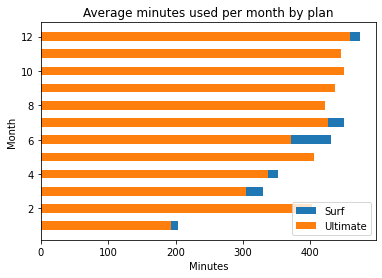

In [202]:
surf_data = average_by_plan_month[average_by_plan_month['plan'] == 'surf']
ultimate_data = average_by_plan_month[average_by_plan_month['plan'] == 'ultimate']

plt.barh(surf_data['month'], surf_data['min_amount'], height=0.5, label='Surf')

plt.barh(ultimate_data['month'], ultimate_data['min_amount'], height=0.5, label='Ultimate')

plt.title('Average minutes used per month by plan')
plt.xlabel('Minutes')
plt.ylabel('Month')
plt.legend()

En el gráfico se observa que Enero corresponde al mes con menos llamdas del año, y que por lo general los usuarios de Surf tienden a usar más minutos en promedio.

El siguiente histograma muestra la cantidad de minutos que los usarios de cada plan requieren cada mes. Para facilitar la lectura del histograma, se presentan por separado según el plan, presentando primero a Surf y luego a Ultimate.

Text(0, 0.5, 'frequency')

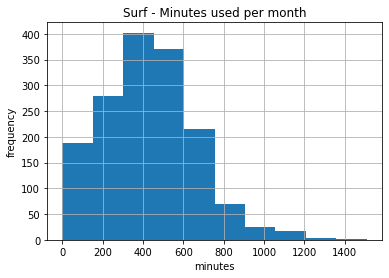

In [203]:
surf.hist('min_amount')
plt.title('Surf - Minutes used per month')
plt.xlabel('minutes')
plt.ylabel('frequency')

El gráfico muestra que una parte de los usuarios sobrepasa el límite de los 500 minutos al mes. Algunas personas sobrepasan los minutos en tal cantidad que sería posible convencerlos de pagar una tarifa fija más elavada como la de Ultimate, a fin de reducir sus costos en excesod de minutos.

Text(0, 0.5, 'frequency')

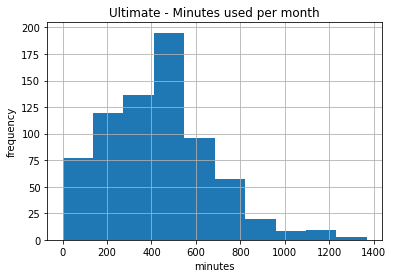

In [204]:
ultimate.hist('min_amount')
plt.title('Ultimate - Minutes used per month')
plt.xlabel('minutes')
plt.ylabel('frequency')

El gráfico muestra que los usuarios no sobrepasan el límite de los 3000 minutos al mes, por lo que Megaline podría repensar este límite, y quizás bajarlo para así generar ganancias mediante el exceso de minutos.

A continuación se muestran la media y la varianza de la duración mensual de las llamadas para ver si el comportamiento de ambas poblaciones es similar o difiere.

In [205]:
print(surf['min_amount'].mean())
print(surf['min_amount'].var())

428.7495232040687
54968.27946065038


In [206]:
print(ultimate['min_amount'].mean())
print(ultimate['min_amount'].var())

430.45
57844.46481223922


Por una parte, la media de la duración mensual de las llamadas para Surf es d 428.74 con una varianza de 54968. Por otra parte, la media de la duración mensual de las llamdas para Ultimate es de 430.45 con una varianza de 57844. Tanto la media como la varianza para ambas poblaciones es similar, por lo que se concluye que el comportamiento en torno al uso de minutos de cada plan es similar. Finalmente, se trazarán diagramas de caja para visualizar la distribución de los datos sobre la duración mensual de las llamadas en cada tarifa de prepago.

Text(0.5, 1.0, 'Surf - Minutes used per month')

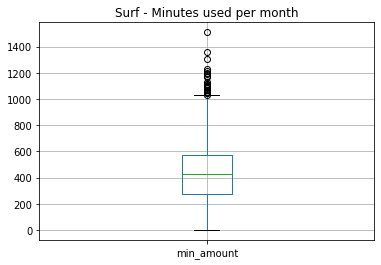

In [207]:
surf.boxplot('min_amount')
plt.title('Surf - Minutes used per month')

El diagrama de caja para Surf confirma el valor de la media calculado previamente y muestra valores atípicos por arriba de la media.

Text(0.5, 1.0, 'Ultimate - Minutes used per month')

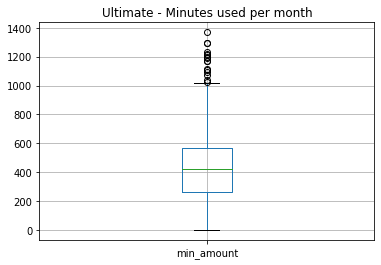

In [208]:
ultimate.boxplot('min_amount')
plt.title('Ultimate - Minutes used per month')

El diagrama de caja para Ultimate también confirma el valor de la media calculado previamente y muestra valores atípicos por arriba de la media.

### Mensajes

A continuación se comparará el número de mensajes que tienden a enviar cada mes los usuarios de cada plan, comenzando con Surf.

Text(0, 0.5, 'frequency')

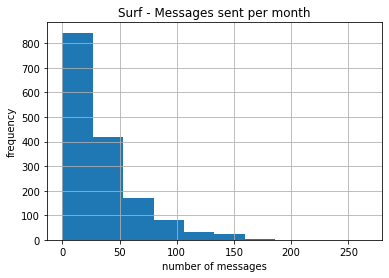

In [158]:
surf.hist('messages_amount')
plt.title('Surf - Messages sent per month')
plt.xlabel('number of messages')
plt.ylabel('frequency')

El histograma muestra una distribución con sesgo a la izquierda, por lo que la mediana será menor que la media. La mayoría de los usuarios no exceden el límite de los 50 SMS al mes.

Text(0, 0.5, 'frequency')

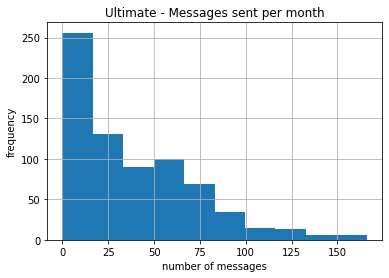

In [159]:
ultimate.hist('messages_amount')
plt.title('Ultimate - Messages sent per month')
plt.xlabel('number of messages')
plt.ylabel('frequency')

In [160]:
print(surf['messages_amount'].mean())
print(surf['messages_amount'].var())

31.15956770502225
1126.7245219504066


In [161]:
print(ultimate['messages_amount'].mean())
print(ultimate['messages_amount'].var())

37.55138888888889
1208.756743548138


Por una parte, la media del uso de mensajes de Surf es de 31.15, con una varianza de 1126. Por otra parte, la media del uso de mensajes para Ultimate es de 37.55 con una varianza de 1208. Tanto la media como la varianza para ambas poblaciones es similar, por lo que se concluye que el comportamiento en torno al uso de mensajes de texto de cada plan es similar. En promedio, los usuarios, ya sean de Surf o Ultimate, no exceden los límites definidos por su plan. Finalmente, se trazarán diagramas de caja para visualizar la distribución de los datos sobre los mensajes en cada tarifa de prepago.

Text(0.5, 1.0, 'Surf - Messages sent per month')

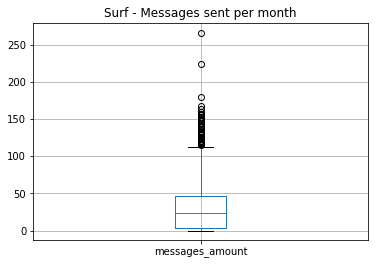

In [162]:
surf.boxplot('messages_amount')
plt.title('Surf - Messages sent per month')

El diagrama de caja para Surf confirma el valor de la media calculado previamente y muestra valores atípicos por arriba de la media.

Text(0.5, 1.0, 'Ultimate - Minutes used per month')

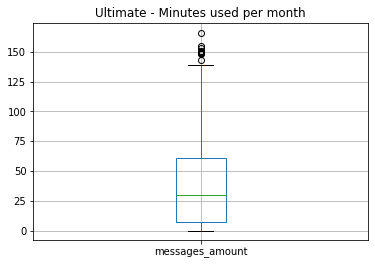

In [163]:
ultimate.boxplot('messages_amount')
plt.title('Ultimate - Minutes used per month')

El diagrama de caja para Ultimate confirma el valor de la media calculado previamente y muestra valores atípicos por arriba de la media.

### Internet

Finalmente, se compara la cantidad de tráfico de internet consumido en gb por usuarios por plan, comenzando por Surf.

Text(0, 0.5, 'frequency')

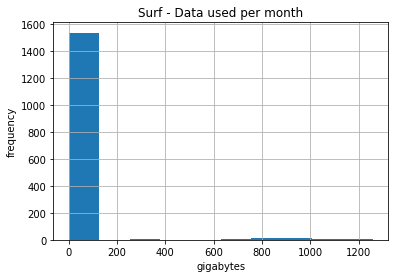

In [242]:
surf.hist('gb_used_monthly')
plt.title('Surf - Data used per month')
plt.xlabel('gigabytes')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

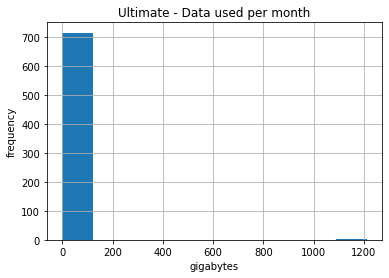

In [219]:
ultimate.hist('gb_used_monthly')
plt.title('Ultimate - Data used per month')
plt.xlabel('gigabytes')
plt.ylabel('frequency')

Nuevamente se observan algunos datos que parecerían ser atípicos, excediendo los 200 GB de uso mensual.

Gran parte los usuarios exceden el límite de 13 GB de Ultimate, la distribucion no presenta sesgos. Es curioso que al ser Ultimate una tarifa más cara, incluya menos datos que Surf, por lo que Megaline podría repensar ese límite para hacer parecer a Ultimate como un plan más conveniente también en términos de datos móviles disponibles.

In [243]:
print(surf['gb_used_monthly'].mean())
print(surf['gb_used_monthly'].var())

21.645899554990464
19386.041835911026


In [245]:
print(ultimate['gb_used_monthly'].mean())
print(ultimate['gb_used_monthly'].var())

6.4375
6019.050330319888


La media de datos móviles usados por usuarios de Surf es de 21 GB en un mes, con una gran varianza de 193886,04 mientras que la media para usuarios de Ultimate es de solo 6 GB con una varianza de 6019,05. Dichos números, junto a los gráficos anteriores, muestran que posiblemente hay datos atípicos en el uso de GB para ambos planes.

Text(0.5, 1.0, 'Surf - Data used per month')

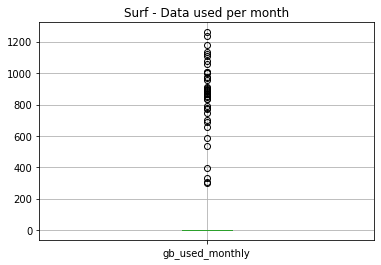

In [174]:
surf.boxplot('gb_used_monthly')
plt.title('Surf - Data used per month')

El diagrama de caja para Surf confirma la existencia de datos atípicos muy por fuera de la media.

Text(0.5, 1.0, 'Ultimate - Data used per month')

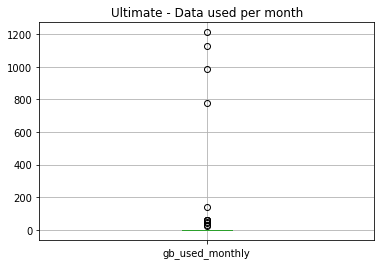

In [171]:
ultimate.boxplot('gb_used_monthly')
plt.title('Ultimate - Data used per month')

El diagrama de caja para Ultimate confirma la existencia de datos atípicos muy por fuera de la media.

## Ingreso

A continuación se comparará el ingreso que generá cada plan para Megaline.

In [222]:
total_profit_month_plan = monthly_revenue_info.groupby(['plan','month'])['revenue'].sum().reset_index()
total_profit_month_plan

,plan,month,revenue
0,surf,1,40.00
1,surf,2,189.57
2,surf,3,5676.65
3,surf,4,10585.53
4,surf,5,19857.37
5,surf,6,28619.80
6,surf,7,30003.56
7,surf,8,42726.85
8,surf,9,49444.67
9,surf,10,53104.83


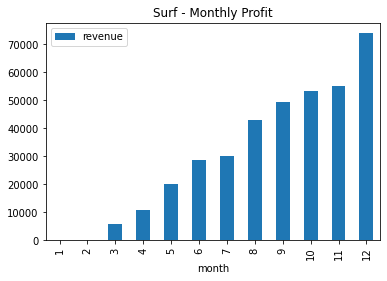

In [223]:
total_profit_month_plan[total_profit_month_plan['plan'] == 'surf'].plot(y='revenue', x='month', kind='bar')
plt.title('Surf - Monthly Profit');

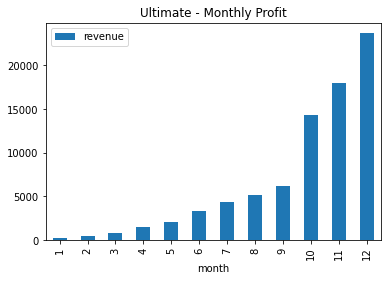

In [224]:
total_profit_month_plan[total_profit_month_plan['plan'] == 'ultimate'].plot(y='revenue', x='month', kind='bar')
plt.title('Ultimate - Monthly Profit');

Los gráficos muestran distribuciones similares para ambos planes, pero con más ganancias en Surf que en Ultimate. Además, ambos tienden a generar más ganancias a medida que pasa el año.

## Probar las hipótesis estadísticas.

A continuación se examinarán dos hipótesis. La primera (A)establece que el ingreso promedio de los usuarios de las tarifas Surf y Ultimate difiere. La segunda (B) establace que el ingreso promedio de los usuarios de Nueva York y Nueva Jersey es diferente al de los usuarios de otras regiones. Para examinar la hipótesis B, se creará un nuevo dataframe que entregue información de los ingresos para Megaline según el estado de los usuarios.

Elaboración de hipótesis (A)
1. H0: La media de ingresos que genera cada usuario para los planes Ultimate y Surf son iguales. 
2. H1: La media de ingresos que genera cada usuario para los planes Ultimate y Surf no son iguales. 

Se establece un nivel de significancia del 5% y se usará la prueba stats.ttest_ind de la librería scipy para probar las hipótesis sobre la igualdad de las medias de dos poblaciones estadísticamente distintas.

In [225]:
sample_1 = surf['revenue']
sample_2 = ultimate['revenue']

In [231]:
alpha = 0.05 

results = st.ttest_ind(
                        sample_1, 
                        sample_2,
                        equal_var=False)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("Se rechaza la hipótesis nula")
else:
        print("No se rechaza la hipótesis nula")

p-value:  0.001921281018729421
Se rechaza la hipótesis nula


Se rechaza la hipótesis nula, es decir, se rechaza que la media de ingresos que generan los usuarios de Ultimate y Surf son iguales.

Elaboración de hipótesis (B)
1. H0: La media de ingresos que generan los usuarios de NY y NJ son iguales que a la media de los usuarios de otros estados.
1. H0: La media de ingresos que generan los usuarios de NY y NJ no son iguales que a la media de los usuarios de otros estados.

In [233]:
city_revenue = pd.merge(monthly_revenue_info, users[['user_id', 'city']], on='user_id')
city_revenue

,user_id,month,calls_amount,messages_amount,gb_used_monthly,min_amount,plan,messages_included,mb_per_month_included,minutes_included,...,usd_per_message,usd_per_minute,excess_messages,excess_minutes,excess_data,message_price,call_price,gb_price,revenue,city
0,1000,12,16.0,11.0,64.0,124.0,ultimate,1000,30720,3000,...,0.01,0.01,0.0,0.0,34.0,0.00,0.0,238.0,308.00,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,27.0,30.0,393.0,182.0,surf,50,15360,500,...,0.03,0.03,0.0,0.0,378.0,0.00,0.0,3780.0,3800.00,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,49.0,44.0,1001.0,315.0,surf,50,15360,500,...,0.03,0.03,0.0,0.0,986.0,0.00,0.0,9860.0,9880.00,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,65.0,53.0,881.0,393.0,surf,50,15360,500,...,0.03,0.03,3.0,0.0,866.0,0.09,0.0,8660.0,8680.09,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,64.0,36.0,959.0,426.0,surf,50,15360,500,...,0.03,0.03,0.0,0.0,944.0,0.00,0.0,9440.0,9460.00,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,12,0.0,78.0,0.0,0.0,ultimate,1000,30720,3000,...,0.01,0.01,0.0,0.0,0.0,0.00,0.0,0.0,70.00,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2289,1349,10,0.0,76.0,0.0,0.0,surf,50,15360,500,...,0.03,0.03,26.0,0.0,0.0,0.78,0.0,0.0,20.78,"Boston-Cambridge-Newton, MA-NH MSA"
2290,1349,11,0.0,72.0,0.0,0.0,surf,50,15360,500,...,0.03,0.03,22.0,0.0,0.0,0.66,0.0,0.0,20.66,"Boston-Cambridge-Newton, MA-NH MSA"
2291,1349,12,0.0,61.0,0.0,0.0,surf,50,15360,500,...,0.03,0.03,11.0,0.0,0.0,0.33,0.0,0.0,20.33,"Boston-Cambridge-Newton, MA-NH MSA"


In [234]:
ny_nj_users = city_revenue[city_revenue['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']
other_users = city_revenue[city_revenue['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']

In [235]:
sample_3 = ny_nj_users['revenue']
sample_4 = other_users['revenue']

In [236]:
alpha = 0.05 

results = st.ttest_ind(sample_3, sample_4)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("Se rechaza la hipótesis nula")
else:
        print("No se rechaza la hipótesis nula")

p-value:  0.00265371922021487
Se rechaza la hipótesis nula


Se rechaza la hipótesis nula, es decir, se rechaza que la media de ingresos que generan los usuarios de NY y NJ son iguales que a la media de los usuarios de otros estados.

## Conclusión general



En este reporte se analizó la conducta de los usuarios de las tarifas de prepago Surf y Ultimate de la empresa de telecomunicaciones Megaline, con el objetivo de saber cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad.

En el preprocesamiento de datos, se cambiaron todas las variables de tiempo al formato datetime. Además, se redondearon los minutos de las llamadas siguiendo las políticas de la empresa y se convirtió el uso de datos de MB a GB. No se encontraron datos ausentes en los dataframes.

Luego, se calcularon el total de minutos usados por mes, el total de SMS enviados por mes y el volumen de datos usados por mes. Esta información fue útil para generar los ingresos que genera cada usuario al mes, añadiendole a su tarifa fija de pago mensual los excesos, ya sean de minutos, mensajes o internet, que pueden haber hecho durante cada mes.

Con dicha información se realizó un análisis exploratorio de datos que reveló que el comportamiento de los usuarios de Surf y Ultimate es extremadamente similar, sin importar el servicio en particular que se analice. Sin embargo, al ofrecer Surf un plan limitado, tiende a generar más ganancias para Megaline.

Las distribuciones de datos para Surf y Ultimate se mostraron similares también, con una media de minutos de 428 y 430, media de SMS de 31 y 37, y media de datos móviles en GB de 21 y y 6 respectivamente. Llama la atención que solo en este apartado los usuarios de Surf y Ultimate tienden a tener un comportamiento disímil, y es probable que se deba a la presencia de datos atípicos en la muestra.

Finalmente, en cuanto a las pruebas de hipótesis, estás fueron trabajadas con un nivel de significancia del 5%, y se usaron pruebas para poblaciones distintas de la librería scipy. Se rechazaron ambas hipótesis sobre la igualdad de medias por lo que se recomienda seguir investigando cómo dichas medias difieren. 

Para la primera prueba, sobre la media de los ingresos de Surf y Ultimate, habría que evaluar con más profundidad de qué manera cada una genera ingresos, y en qué se ve reflejada la diferencia que podría sugerir la prueba de hipótesis. Cabe recordar que rechazar una hipótesis nula no significa automáticamente aceptar la hipótesis alternativa.

Lo mismo es válido para la hipótesis sobre los ingresos que generan los clientes de Nueva York y Nueva Jersey en comparación a otros estados. Se rechaza la hipótesis nula, y se requiere investigación adicional para concluir al respecto.